In [1]:
"""
Hydropower EDA Notebook
-----------------------------------
Purpose:
- Data integrity checks (shape, dtypes, missingness)
- Target distribution + log distribution
- Group comparisons (mode, regions)
- Seasonality (month), interannual trend (year)
- Spatial quicklook (lon/lat colored by MWh)
- Correlation heatmap (numeric)
- Static-feature vs target log–log relationships
- Climate-feature vs target relationships (sampled)
- Spearman correlations ranked by association with target

Notes:
- Plots on very large data can be slow; we sample for speed.
- We use log scales for heavy-tailed variables to reveal structure.
- Interpret plots in the context of Storage vs RoR operational modes.
"""

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # convenient for quick EDA plots

# === Settings for reproducibility / aesthetics ===
pd.set_option("display.max_columns", 200)
sns.set_context("talk", font_scale=0.9)

# === Load dataset ===
df = pd.read_csv("train_val_2001_2021.csv")




In [3]:
# ------------------------------
# 1) BASIC DATA HEALTH CHECKS
# ------------------------------
print(f"Rows: {len(df):,}  |  Columns: {df.shape[1]}")

# % missing by column (top 10). If all zeros, great — no imputation needed.
missing_pct = (df.isna().mean().sort_values(ascending=False) * 100)
print("Top-10 missingness (% by column):", missing_pct.head(10))

# Data types — make sure categoricals aren't mis-typed numerics and vice versa.
print("Data types:", df.dtypes)

# Identify numeric columns once for reuse
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Basic numeric summary — quick sanity check on ranges/outliers.
print("Numeric summary (describe):", df[num_cols].describe().T)



Rows: 294,336  |  Columns: 22
Top-10 missingness (% by column): year               0.0
month              0.0
RectifHyd_MWh      0.0
mode               0.0
Latitude           0.0
Longitude          0.0
nerc_region        0.0
Primary Purpose    0.0
Dam Height (Ft)    0.0
NID Height (Ft)    0.0
dtype: float64
Data types: year                          int64
month                         int64
RectifHyd_MWh               float64
mode                         object
Latitude                    float64
Longitude                   float64
nerc_region                  object
Primary Purpose              object
Dam Height (Ft)             float64
NID Height (Ft)             float64
Dam Length (Ft)             float64
Year Completed              float64
NID Storage (Acre-Ft)       float64
Max Storage (Acre-Ft)       float64
Normal Storage (Acre-Ft)    float64
Surface Area (Acres)        float64
Drainage Area (Sq Miles)    float64
Division_ID                   int64
tmin                        flo

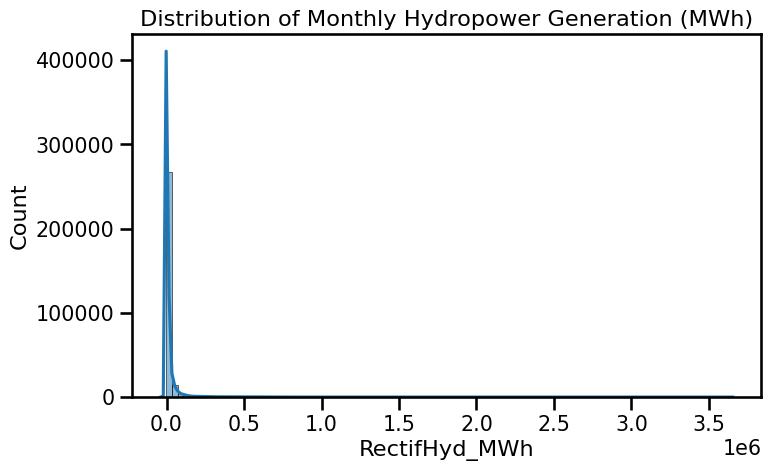

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


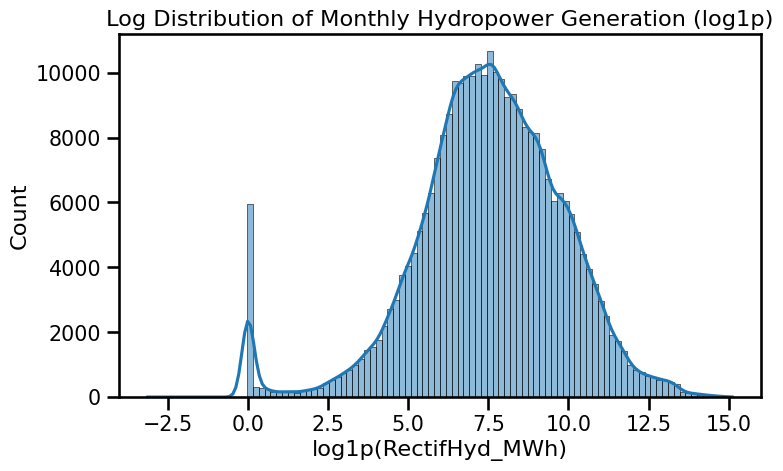

In [4]:
# ------------------------------
# 2) TARGET DISTRIBUTION
# ------------------------------
# The target is monthly MWh. Generation is typically heavy‑tailed:
#   - many low/moderate values, few very large months.
# We show both raw and log1p distributions.

plt.figure(figsize=(8, 5))
sns.histplot(df["RectifHyd_MWh"], bins=100, kde=True)
plt.title("Distribution of Monthly Hydropower Generation (MWh)")
plt.xlabel("RectifHyd_MWh")
plt.ylabel("Count")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df["RectifHyd_MWh"]), bins=100, kde=True)
plt.title("Log Distribution of Monthly Hydropower Generation (log1p)")
plt.xlabel("log1p(RectifHyd_MWh)")
plt.ylabel("Count")
plt.tight_layout(); plt.show()



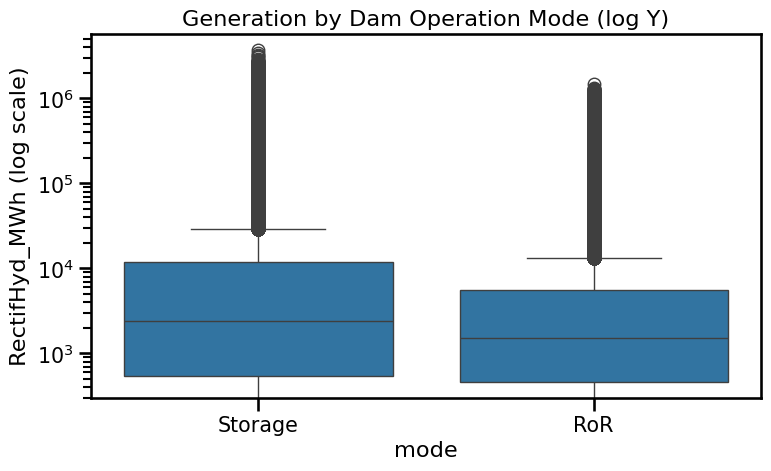

In [5]:
# ------------------------------
# 3) GROUP COMPARISONS (MODE)
# ------------------------------
# Storage plants often show higher variance/peaks; RoR is more flow‑constrained.
# We use a log y‑scale to compress extremes.

plt.figure(figsize=(8, 5))
sns.boxplot(x="mode", y="RectifHyd_MWh", data=df)
plt.yscale("log")
plt.title("Generation by Dam Operation Mode (log Y)")
plt.xlabel("mode")
plt.ylabel("RectifHyd_MWh (log scale)")
plt.tight_layout(); plt.show()



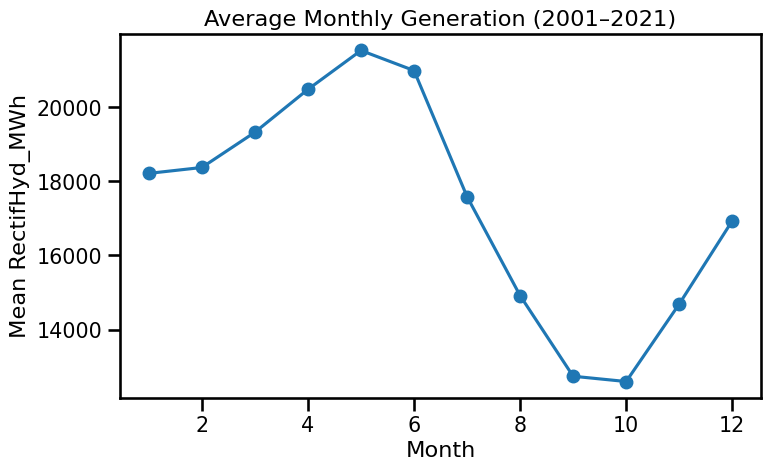

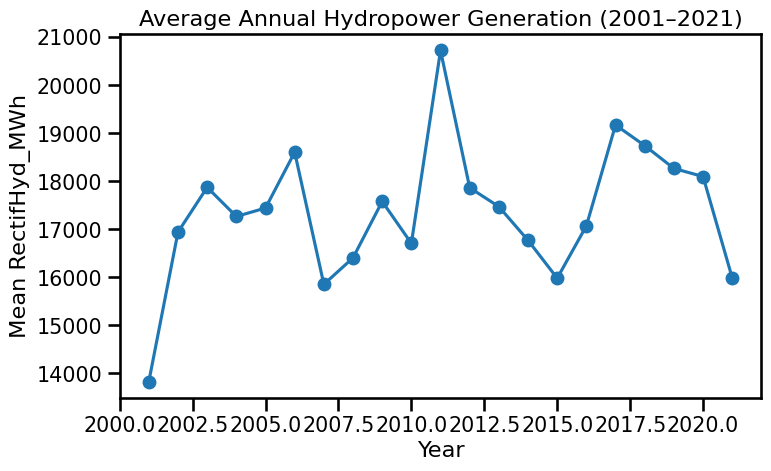

In [6]:
# ------------------------------
# 4) SEASONALITY (MONTH) & INTERANNUAL TREND (YEAR)
# ------------------------------
# Month-of-year mean reveals seasonal cycle. Yearly mean shows long‑term trend.

monthly_mean = df.groupby("month")["RectifHyd_MWh"].mean()
plt.figure(figsize=(8, 5))
monthly_mean.plot(marker="o")
plt.title("Average Monthly Generation (2001–2021)")
plt.xlabel("Month")
plt.ylabel("Mean RectifHyd_MWh")
plt.tight_layout(); plt.show()

yearly_mean = df.groupby("year")["RectifHyd_MWh"].mean()
plt.figure(figsize=(8, 5))
yearly_mean.plot(marker="o")
plt.title("Average Annual Hydropower Generation (2001–2021)")
plt.xlabel("Year")
plt.ylabel("Mean RectifHyd_MWh")
plt.tight_layout(); plt.show()



/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


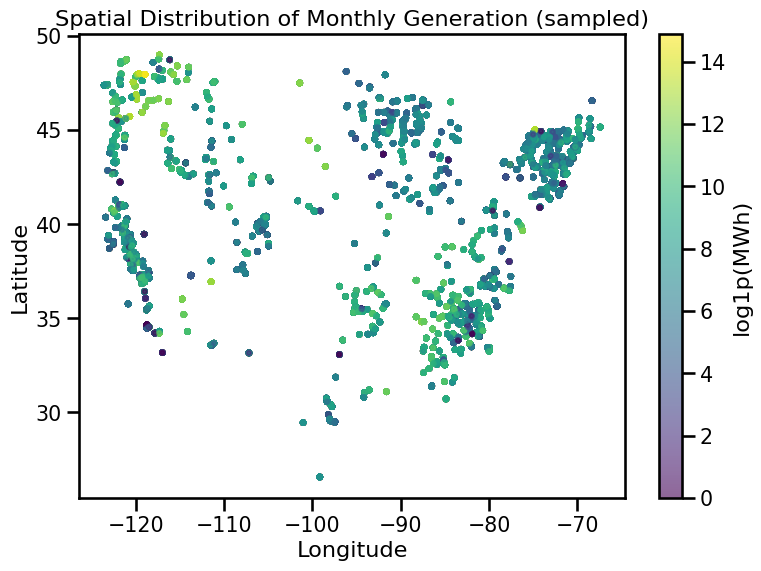

In [7]:
# ------------------------------
# 5) SPATIAL QUICKLOOK
# ------------------------------
# Quick scatter of Lon/Lat, colored by log1p(MWh). This is a coarse view —
# not a map projection — but good enough to spot regional clusters.

# For speed, sample at most ~100k points if the dataset is huge.
N = min(len(df), 100_000)
df_sp = df.sample(N, random_state=42) if len(df) > N else df

plt.figure(figsize=(8, 6))
sc = plt.scatter(df_sp["Longitude"], df_sp["Latitude"],
                 c=np.log1p(df_sp["RectifHyd_MWh"]), s=10, alpha=0.6, cmap="viridis")
plt.colorbar(sc, label="log1p(MWh)")
plt.title("Spatial Distribution of Monthly Generation (sampled)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.tight_layout(); plt.show()


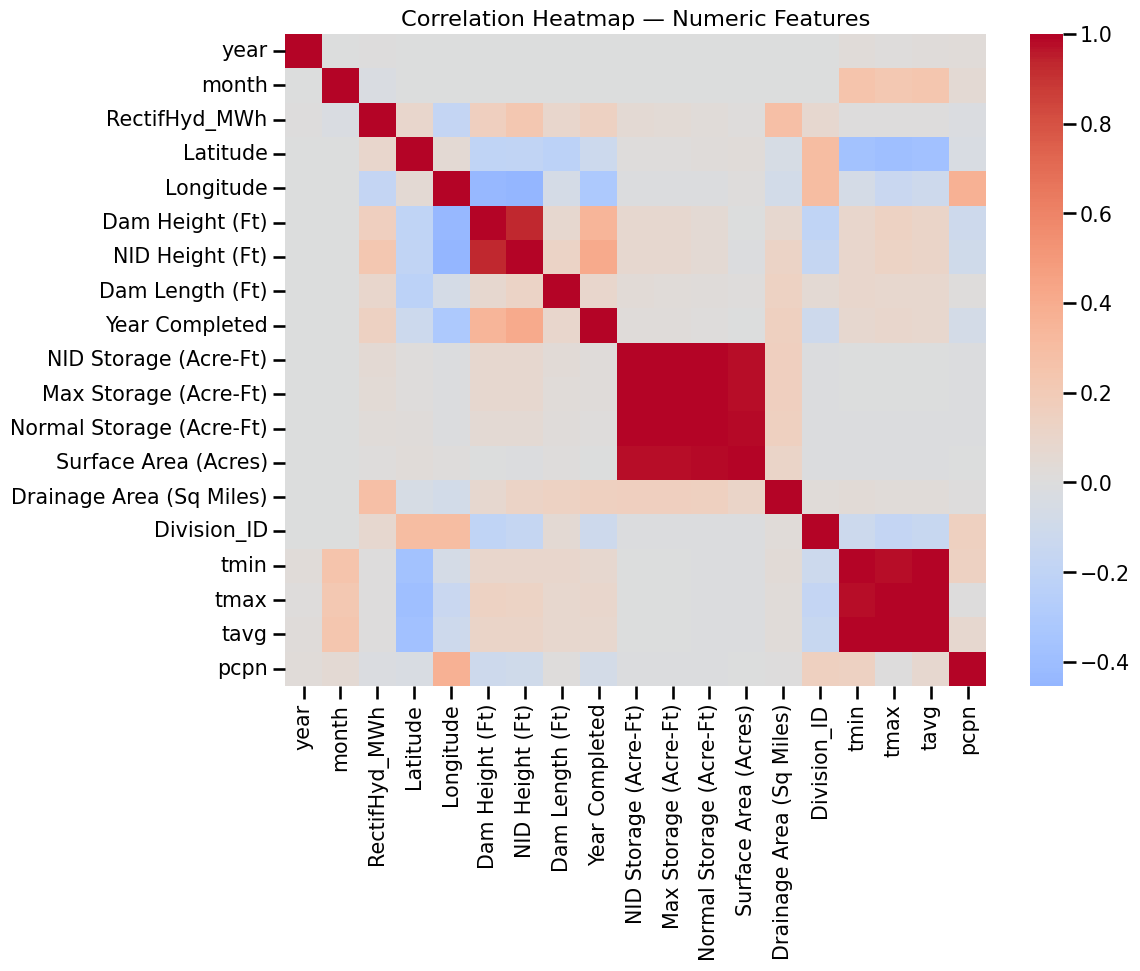

In [8]:
# ------------------------------
# 6) CORRELATION HEATMAP (NUMERIC)
# ------------------------------
# Pearson correlations across numeric columns. This exposes collinearity
# (e.g., storage metrics) and rough linear associations.

plt.figure(figsize=(12, 10))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0, square=False)
plt.title("Correlation Heatmap — Numeric Features")
plt.tight_layout(); plt.show()



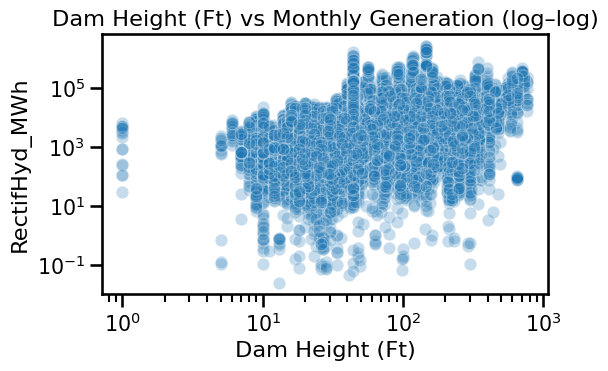

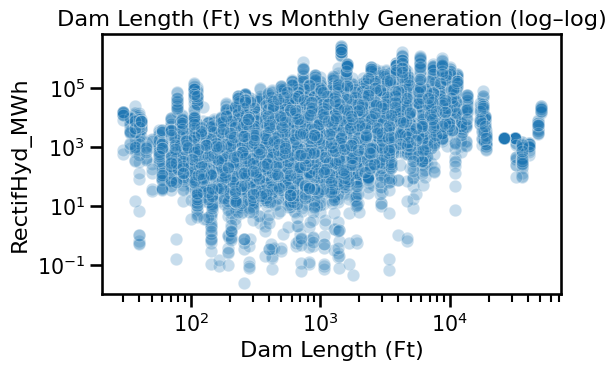

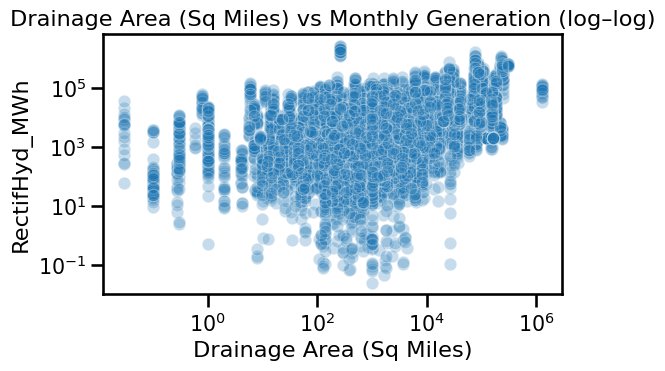

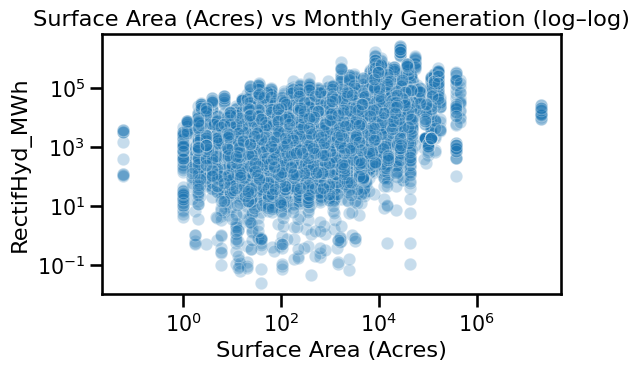

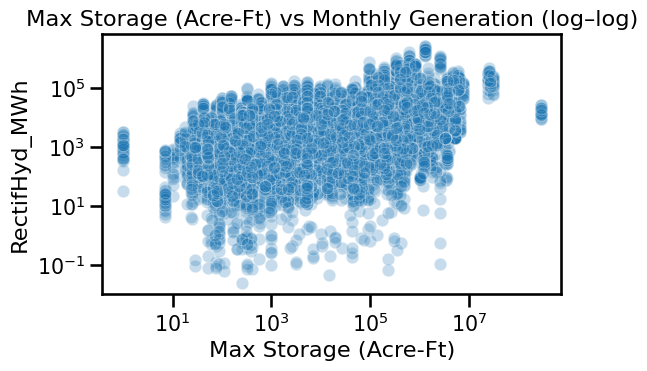

In [9]:
# ------------------------------
# 7) STATIC FEATURE RELATIONSHIPS (LOG–LOG)
# ------------------------------
# Structural variables vs generation. Log–log reduces leverage of giants and
# often linearizes power‑law‑like relationships.

static_feats = [
    "Dam Height (Ft)",
    "Dam Length (Ft)",
    "Drainage Area (Sq Miles)",
    "Surface Area (Acres)",
    "Max Storage (Acre-Ft)",
]

for feat in static_feats:
    # guard against missing columns in case schema changes
    if feat in df.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=feat, y="RectifHyd_MWh", data=df.sample(min(20000, len(df)), random_state=7), alpha=0.25)
        plt.xscale("log"); plt.yscale("log")
        plt.title(f"{feat} vs Monthly Generation (log–log)")
        plt.tight_layout(); plt.show()


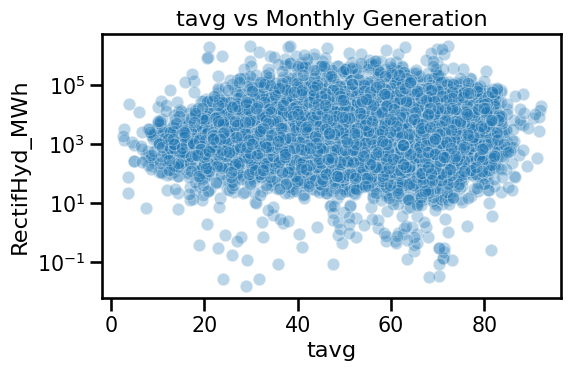

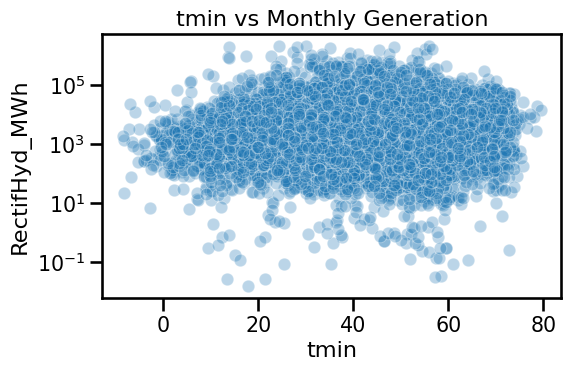

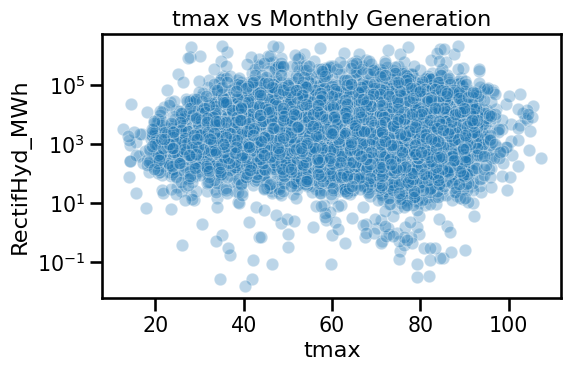

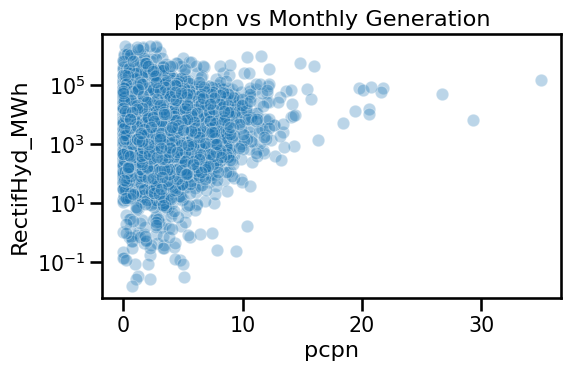

In [10]:

# ------------------------------
# 8) CLIMATE RELATIONSHIPS
# ------------------------------
# Simple scatter checks between monthly climate and generation. We sample to
# keep plots responsive. Consider adding lags later in modeling.

climate_vars = ["tavg", "tmin", "tmax", "pcpn"]
for var in climate_vars:
    if var in df.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=var, y="RectifHyd_MWh", data=df.sample(min(10000, len(df)), random_state=123), alpha=0.3)
        plt.yscale("log")
        plt.title(f"{var} vs Monthly Generation")
        plt.tight_layout(); plt.show()



In [12]:
# ------------------------------
# 9) GROUPED SUMMARIES (MODE / REGION)
# ------------------------------
# Quick tables to quantify group effects that we saw visually.

print("Mean/Spread of Generation by Mode:", df.groupby("mode")["RectifHyd_MWh"].describe())

if "nerc_region" in df.columns:
    print("Mean Generation by NERC Region (descending):",
          df.groupby("nerc_region")["RectifHyd_MWh"].mean().sort_values(ascending=False))



Mean/Spread of Generation by Mode:             count          mean           std         min         25%  \
mode                                                                    
RoR      119700.0  13268.250943  61608.792721      0.0000  467.777900   
Storage  174636.0  20172.269188  88952.806830 -39403.7356  541.387925   

                50%          75%           max  
mode                                            
RoR      1514.66375   5604.43695  1.463079e+06  
Storage  2398.18375  12004.66820  3.653591e+06  
Mean Generation by NERC Region (descending): nerc_region
WECC    36270.267940
SERC    16523.557889
MRO      9057.029877
RFC      6742.864056
NPCC     4448.579230
TRE      2762.940416
Name: RectifHyd_MWh, dtype: float64


In [14]:
# ------------------------------
# 10) SPEARMAN CORRELATIONS WITH TARGET
# ------------------------------
# Rank‑order monotonic associations (more robust to nonlinearity than Pearson).

spearman = df[num_cols].corr(method="spearman")["RectifHyd_MWh"].sort_values(ascending=False)
print("Top 15 Spearman correlations with RectifHyd_MWh:", spearman.head(15))
print("Bottom 15 Spearman correlations with RectifHyd_MWh:", spearman.tail(15))

# ------------------------------
# 11) OPTIONAL: QUICK DATA CLEAN SUGGESTIONS
# ------------------------------
# Negative MWh values are likely corrections/flags; consider clipping to 0.
neg_count = (df["RectifHyd_MWh"] < 0).sum()
if neg_count:
    print(f"NOTE: Found {neg_count:,} negative MWh rows — consider RectifHyd_MWh = max(MWh, 0)")

# Suggest log1p target transform if very skewed (rule‑of‑thumb check)
skew = df["RectifHyd_MWh"].skew()
if skew > 1:
    print(f"Skewness of RectifHyd_MWh is {skew:.2f} (>1). A log1p transform will likely help linear models.")

print("EDA complete. Review plots and tables above for modeling decisions (lags, splits, transforms, and feature selection).")

Top 15 Spearman correlations with RectifHyd_MWh: RectifHyd_MWh               1.000000
NID Height (Ft)             0.495065
Normal Storage (Acre-Ft)    0.483589
NID Storage (Acre-Ft)       0.475315
Dam Height (Ft)             0.454493
Max Storage (Acre-Ft)       0.450931
Surface Area (Acres)        0.443589
Dam Length (Ft)             0.425178
Drainage Area (Sq Miles)    0.408264
Year Completed              0.319618
tmax                        0.026610
tavg                        0.021564
tmin                        0.016196
pcpn                       -0.001189
year                       -0.002778
Name: RectifHyd_MWh, dtype: float64
Bottom 15 Spearman correlations with RectifHyd_MWh: Dam Height (Ft)             0.454493
Max Storage (Acre-Ft)       0.450931
Surface Area (Acres)        0.443589
Dam Length (Ft)             0.425178
Drainage Area (Sq Miles)    0.408264
Year Completed              0.319618
tmax                        0.026610
tavg                        0.021564
tmin        